In [151]:
import ee

from IPython.display import Image

ee.Authenticate() #Usual authentication, so far. Nothing new


Successfully saved authorization token.


In [152]:
ee.Initialize()

In [153]:
#Function to download images as a list - thanks Connor Finn. 
def get_images(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
  image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

  images = list(map(lambda x: ee.Image(x), image_ids))

  return images

In [154]:
'''
Functions needed to display images and features/featurecollections are given here. 
These functions are all from other sources. Mostly from google tutorials.
'''
!pip install geojson
!pip install pygeoj
import geojson
import json
import pygeoj
import numpy as np


import folium


# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [155]:
p = [144]
r = [48]
sat = 'LANDSAT/LC08/C01/T1'
sd = '2013-05-01'
ed = '2020-05-01'
cc= 5

image_list = get_images(p, r, sat, sd, ed, cc)

In [157]:
def addBandsToLandsat8_NDWI_NDVI_PixelLonLat(image):
  '''
  Function to add bands NDWI, NDVI, and PixelLonLat to a Landsat8 image
  '''
  ndwi = image.normalizedDifference(['B3', 'B6']).rename('ndwi')
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
  imgpixLonLat = image.pixelLonLat()

  image1 = image.addBands(ndwi).addBands(ndvi).addBands(imgpixLonLat)

  return image1

In [159]:
roisite = ee.Geometry.Rectangle([77999/1000, 17135/1000, 78889/1000, 17701/1000]);

In [293]:
import urllib, zipfile, os
import cv2 as cv2
import numpy as np
import pandas as pd

from skimage import io

#training = inputimg.sample({'region': nycsite, 'scale': 30.0, 'numPixels': 5000});
bandToBeUsed = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'ndwi', 'ndvi']

jsonfilepath = '/home/arvindn/Research/TopicsOfInterest/Agriculture/Notes/AlmostCircleAroundHyderabad.json'
with open(jsonfilepath) as f:
    data = geojson.load(f)

coords = np.array(data['features'][0]['geometry']['coordinates'][0])[:,0:2].tolist()

eeGeom = ee.Geometry.Polygon(coords)

eeFeat = ee.Feature(eeGeom)

parameters = {'min': 0,
              'max': 1,
              'scale': 30,
            'palette': ['white', 'blue'],
             'crs': inputimg.select(['B1']).projection().getInfo()['crs']}

lake_hussain = (1480, 1444)
lake_osman = (858, 1599)
lake_himayat = (1068, 1806)

hussain_area = pd.DataFrame()

for inputimg in image_list:

    inputimgWithAddedBands = addBandsToLandsat8_NDWI_NDVI_PixelLonLat(inputimg)
    
    '''
    ############## This part is for unsupervised classification of images into built, water, and vegetation #####
    training = inputimgWithAddedBands.select(bandToBeUsed).sample(region = roisite, scale = 30.0, numPixels = 5000); #Training is based on 500 randomly chosen pizels from within NYC area
    numClusters = 3 #Number of clusters, I suspect. I think this should correspond to urban, non-urban, and water.
    clusterer = ee.Clusterer.wekaKMeans(numClusters).train(training) #Not sure what wekaMeans is - just the code used in the GEE tutorial
    result = inputimgWithAddedBands.cluster(clusterer); #Clustered result
    ############################### End of unsupervised classification #########################################
    '''
    
    waterThreshold = 0.05 #Why do I set this as the threshold?
    greenThreshold = 0.2
    waterRegion = inputimgWithAddedBands.select(['ndwi']).gt(waterThreshold)
    greenRegion = inputimgWithAddedBands.select(['ndvi']).gt(greenThreshold)
    
    waterDownloadURL = waterRegion.select(['ndwi']).clip(eeGeom).getDownloadURL(parameters)
    
    date_acq = inputimg.get('DATE_ACQUIRED').getInfo()
    wrs_path = inputimg.get('WRS_PATH').getInfo()
    wrs_row = inputimg.get('WRS_ROW').getInfo()

    zipfilename = str(date_acq)+'_'+str(wrs_path)+'_'+str(wrs_row)+'_NearHyderabad.zip'
    urllib.request.urlretrieve(waterDownloadURL, zipfilename)
    
    zipf = zipfile.ZipFile(zipfilename, 'r')
    zipf.extractall()

    tif_filename = zipfilename.split('.')[0]+'.tif'
    os.rename('download.ndwi.tif', tif_filename)
    
    waterInROI = io.imread(tif_filename)
    ret,thresh = cv2.threshold(waterInROI,0.5,255,0) #thresholding, this time using OpenCV
    
    #Drawing contours - not sure how openCV does it.
    contours, hierarchy = cv2.findContours(thresh, 
                                           cv2.RETR_TREE, 
                                           cv2.CHAIN_APPROX_SIMPLE)
    
    a = map(cv2.pointPolygonTest, contours, (lake_hussain,)*len(contours),
       (False,)*len(contours)) 
    
    aNumpy = np.array(list(a))
    cnt_Hussain = np.where(aNumpy>0)[0][0]
    
    #print(cnt_Hussain)
    contoursArea = map(cv2.contourArea, contours)
    contoursAreaNumpy = np.sort(list(contoursArea))
    fivemax = np.sort(contoursAreaNumpy)[-5:]*900/1e6 #area in km^2
        
    hussain_area = hussain_area.append(pd.DataFrame([[date_acq, 
                                                     cv2.contourArea(contours[cnt_Hussain])*900/1e6]],
                                                   columns = ['date', 'Hussain area']))

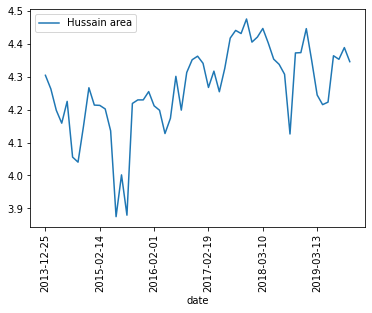

In [365]:
hussain_area.plot(x='date', y='Hussain area', rot=90) #Not a good way of plotting

In [361]:
import glob

lake_hussain = (1480, 1444) # I determined that these points must lie within Hussain Sagar
lake_osman = (858, 1599) # I determined that these points must lie within Osman Sagar
lake_himayat = (1068, 1806) # I determined that these points must lie within Himayat Sagar

'''
This method is based on the analysis of all the tif files of water bodies I 
have near Hyderabad that I have downloaded. I'm looking for the areas of 
the three lakes in the vicinity of Hyderabad. Osman and Himayat sagar
shrink quite a bit - sometimes, they are not even visible in the picture.
Hence, NaN for some entries.

Hussain sagar is all year round. So, I can get an area for every image 
I download. polygonTest determines if a particular point is within a contour.
If so, that determines a lake of nterest. I have chosen one point for each 
of the three lakes. I'm going to determine a countour containing the point
of interest. Chances are there is only one such contour. The point will be
exterior to all other contours.
'''

threelakes_area = pd.DataFrame()

for tif_filename in glob.glob('*_NearHyderabad.tif'):
    waterInROI = io.imread(tif_filename)
    ret,thresh = cv2.threshold(waterInROI,0.5,255,0) #thresholding, this time using OpenCV
    
    #Drawing contours - not sure how openCV does it.
    contours, hierarchy = cv2.findContours(thresh, 
                                           cv2.RETR_TREE, 
                                           cv2.CHAIN_APPROX_SIMPLE)
    a = map(cv2.pointPolygonTest, contours, (lake_hussain,)*len(contours),
       (False,)*len(contours))     
    aNumpy = np.array(list(a))
    cnt_Hussain = np.where(aNumpy>0)[0][0]
    area_Hussain = np.where(len(np.where(aNumpy>0)[0]) == 1,
                            cv2.contourArea(contours[np.where(aNumpy>0)[0][0]])*900/1e6, -999)
    area_Hussain = float(area_Hussain)
    
    a = map(cv2.pointPolygonTest, contours, (lake_osman,)*len(contours),
       (False,)*len(contours))     
    aNumpy = np.array(list(a))
    if len(np.where(aNumpy>0)[0]) == 1:
        area_Osman = cv2.contourArea(contours[np.where(aNumpy>0)[0][0]])*900/1e6
        area_Osman = float(area_Osman)
    else:
        area_Osman = np.NaN
    
    a = map(cv2.pointPolygonTest, contours, (lake_himayat,)*len(contours),
       (False,)*len(contours))     
    aNumpy = np.array(list(a))
    if len(np.where(aNumpy>0)[0]) == 1:
        area_Himayat = cv2.contourArea(contours[np.where(aNumpy>0)[0][0]])*900/1e6
        area_Himayat = float(area_Himayat)
    else:
        area_Himayat = np.NaN
    
    date_acq = tif_filename.split('_')[0]
    threelakes_area = threelakes_area.append(pd.DataFrame([[date_acq, area_Hussain,
                                                           area_Osman,
                                                           area_Himayat]],
                                                   columns = ['date', 'Hussain area', 'Osman area', 'Himayat area']))

threelakes_area['date time'] = pd.to_datetime(threelakes_area['date'])
threelakes_area = threelakes_area.sort_values(by='date time')

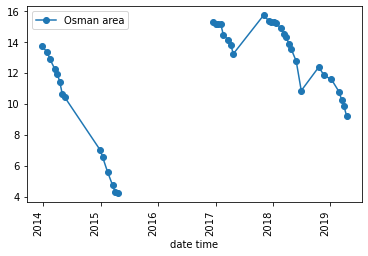

In [362]:
threelakes_area.plot(x='date time', y='Osman area', rot=90, marker='o')

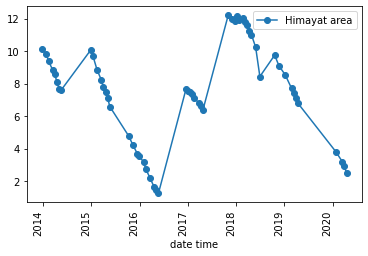

In [363]:
threelakes_area.plot(x='date time', y='Himayat area', rot=90, marker='o')

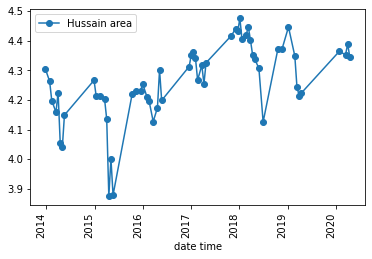

In [364]:
threelakes_area.plot(x='date time', y='Hussain area', rot=90, marker='o')

In [355]:
threelakes_area

,date,Hussain area,Osman area,Himayat area
0,2013-12-25,4.30425,13.69485,10.14075
0,2014-01-26,4.26285,13.33800,9.80055
0,2014-02-11,4.19805,12.90780,9.38160
0,2014-03-15,4.15890,12.24540,8.83620
0,2014-03-31,4.22505,11.91150,8.57520
0,2014-04-16,4.05585,11.41020,8.07210
0,2014-05-02,4.04055,10.61415,7.69455
0,2014-05-18,4.14900,10.41210,7.60185
0,2014-12-28,4.26645,7.02180,10.07100
0,2015-01-13,4.21380,6.56730,9.70785


In [213]:
print(x, y, w, h)

1195 2 3 6


In [268]:
a = map(cv2.pointPolygonTest, contours, ((1480, 1444),)*len(contours),
       (False,)*len(contours)) 

In [269]:
alist = list(a)

In [270]:
aNumpy = np.array(alist)

In [285]:
np.where(aNumpy > 0)[0][0]

610

In [349]:
threelakes_area.sort_values(by='date')

,date,Hussain area,Osman area,Himayat area
0,2013-12-25,4.30425,13.69485,10.14075
0,2014-01-26,4.26285,13.33800,9.80055
0,2014-02-11,4.19805,12.90780,9.38160
0,2014-03-15,4.15890,12.24540,8.83620
0,2014-03-31,4.22505,11.91150,8.57520
0,2014-04-16,4.05585,11.41020,8.07210
0,2014-05-02,4.04055,10.61415,7.69455
0,2014-05-18,4.14900,10.41210,7.60185
0,2014-12-28,4.26645,7.02180,10.07100
0,2015-01-13,4.21380,6.56730,9.70785


In [329]:
len(np.where(aNumpy>0)[0])==1

False

In [336]:
if len(np.where(aNumpy>0)[0]) == 1:
    area_Osman = cv2.contourArea(contours[np.where(aNumpy>0)[0][0]])*900/1e6
else:
    area_Osman = np.NaN
        

print(area_Osman)

nan


In [356]:
threelakes_area['date time'] = pd.to_datetime(threelakes_area['date'])

In [357]:
threelakes_area

,date,Hussain area,Osman area,Himayat area,date time
0,2013-12-25,4.30425,13.69485,10.14075,2013-12-25
0,2014-01-26,4.26285,13.33800,9.80055,2014-01-26
0,2014-02-11,4.19805,12.90780,9.38160,2014-02-11
0,2014-03-15,4.15890,12.24540,8.83620,2014-03-15
0,2014-03-31,4.22505,11.91150,8.57520,2014-03-31
0,2014-04-16,4.05585,11.41020,8.07210,2014-04-16
0,2014-05-02,4.04055,10.61415,7.69455,2014-05-02
0,2014-05-18,4.14900,10.41210,7.60185,2014-05-18
0,2014-12-28,4.26645,7.02180,10.07100,2014-12-28
0,2015-01-13,4.21380,6.56730,9.70785,2015-01-13


In [300]:
date_acq

'2020-04-16'